### Automatically detect and model the background emission using LUCI
In this notebook, we will demonstrate the tools in LUCI to detect and model the background.

To do this, we apply the following steps:
1) Use a segmentation algorithm to find the background pixels
2) Use PCA to construct a subspace representing the background component
    - This includes the sky lines
3) Project each background pixel into a truncated PCA space
4) Interpolate masked pixels into PCA space
    - This can be done by either standard interpolation or using an artificial neural network

All of these steps have been wrapped into a single LUCI call for convenience. Implementation details can be found in our article.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from astroML.correlation import two_point
plt.style.use('/home/carterrhea/Documents/LUCI/light.mplstyle')

In [2]:
# Define user-specific variables
n_components = 50  # Number of PCA components to calculate
n_components_keep = 3  # Number of PCA components to keep
outputDir = '/export/home/carterrhea/NGC4449'  # Output directory for plots and data
Luci_path = '/home/carterrhea/Documents/LUCI/'
cube_dir = '/export/home/carterrhea/NGC4449'  # Path to data cube
cube_name = 'NGC4449_SN3'  # don't add .hdf5 extension
object_name = 'NGC4449'
redshift = 0.0004  # Redshift
resolution = 5000

path = os.path.abspath(Luci_path)
sys.path.insert(0, path)  # add LUCI to the available paths
plt.style.use(os.path.join(Luci_path, 'light.mplstyle'))
from LuciBase import Luci

2023-08-09 15:41:37.119889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 15:41:37.364046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/src/heasoft-6.31.1/x86_64-pc-linux-gnu-libc2.35/lib
2023-08-09 15:41:37.364097: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-09 15:41:40.550993: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror:

In [3]:
cube = Luci(Luci_path, cube_dir+'/'+cube_name, cube_dir, object_name, redshift, resolution, mdn=False)


Reading in data...


100%|███████████████████████████████████████████████████████████████████| 9/9 [00:52<00:00,  5.87s/it]


Existing deep frame extracted from hdf5 file.


2023-08-09 15:53:00.799122: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/src/heasoft-6.31.1/x86_64-pc-linux-gnu-libc2.35/lib
2023-08-09 15:53:00.799169: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-09 15:53:00.799206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dubble): /proc/driver/nvidia/version does not exist
2023-08-09 15:53:00.799570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fla

Epoch 1/50
8188/8188 [==============================] - 27s 3ms/step - loss: 0.1421 - mae: 0.4043 - mape: 547.9698 - val_loss: 0.1741 - val_mae: 0.4485 - val_mape: 759.9442 - lr: 0.0100
Epoch 2/50
8188/8188 [==============================] - 27s 3ms/step - loss: 0.1381 - mae: 0.4020 - mape: 417.7437 - val_loss: 0.1449 - val_mae: 0.4136 - val_mape: 587.2291 - lr: 0.0100
Epoch 3/50
8188/8188 [==============================] - 26s 3ms/step - loss: 0.1385 - mae: 0.4027 - mape: 793.8583 - val_loss: 0.1513 - val_mae: 0.4237 - val_mape: 798.1584 - lr: 0.0100
Epoch 4/50
8188/8188 [==============================] - 26s 3ms/step - loss: 0.1376 - mae: 0.4018 - mape: 548.2436 - val_loss: 0.1269 - val_mae: 0.3868 - val_mape: 259.8147 - lr: 0.0100
Epoch 5/50
8188/8188 [==============================] - 26s 3ms/step - loss: 0.1380 - mae: 0.4026 - mape: 556.0268 - val_loss: 0.1494 - val_mae: 0.4247 - val_mape: 595.2083 - lr: 0.0100
Epoch 6/50
8186/8188 [============================>.] - ETA: 0s - loss

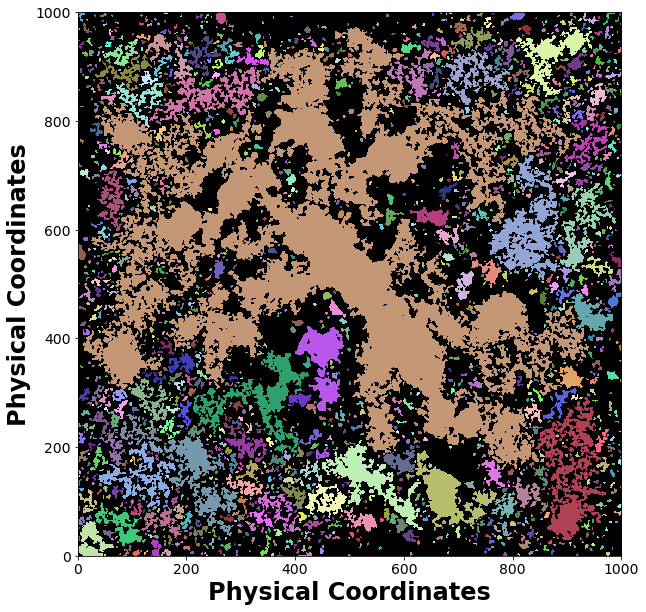

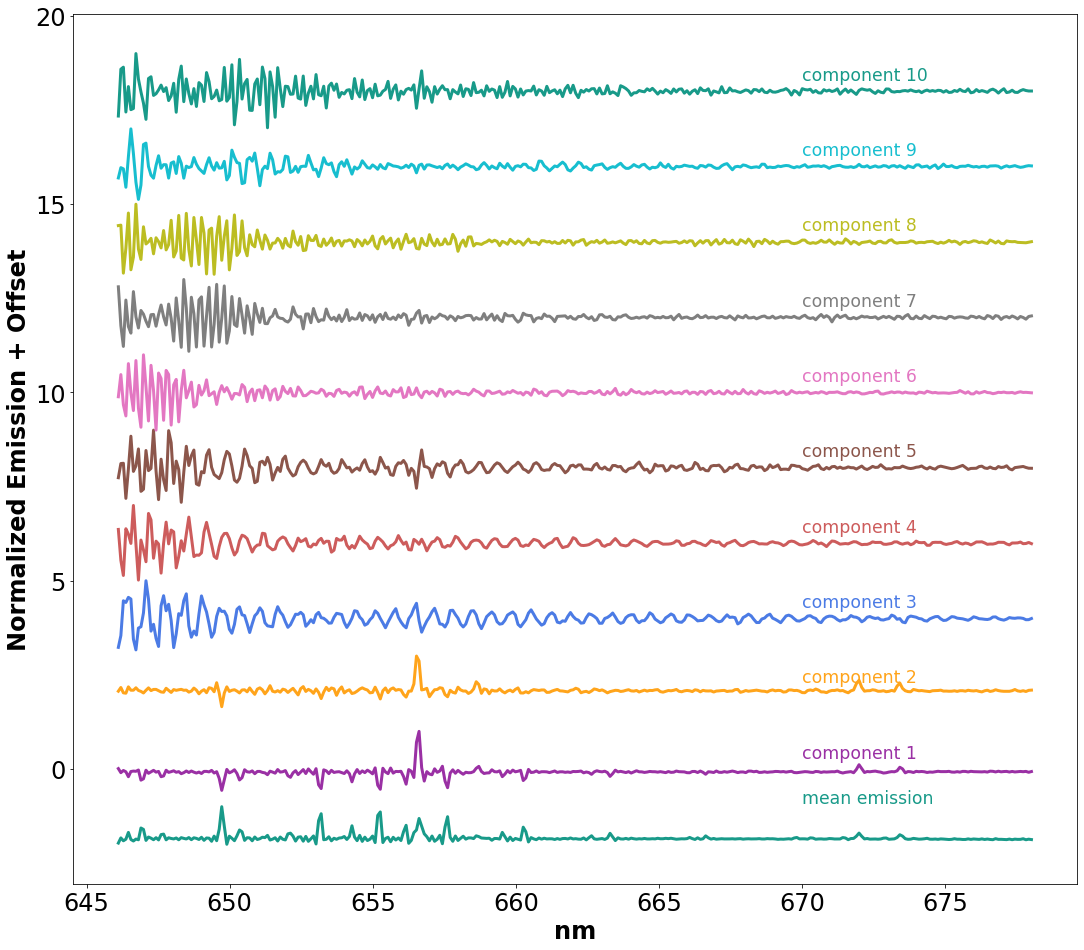

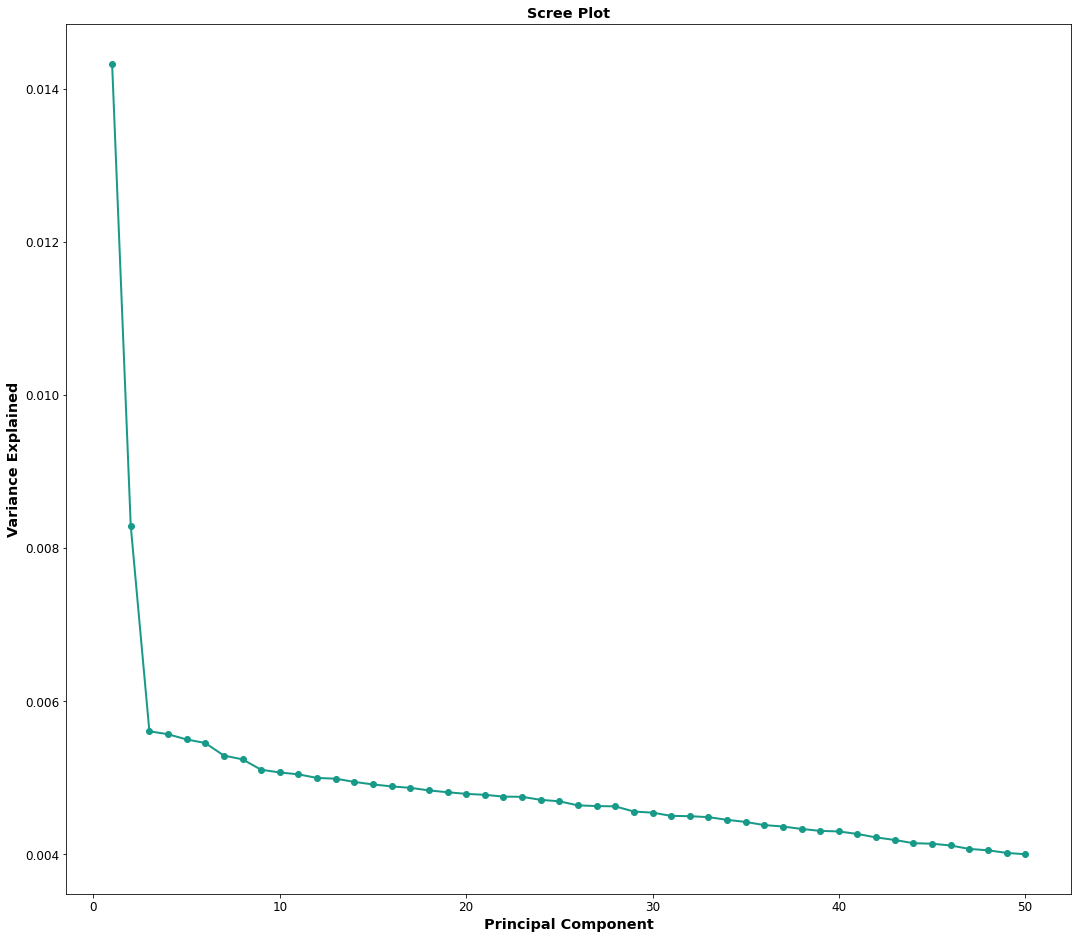

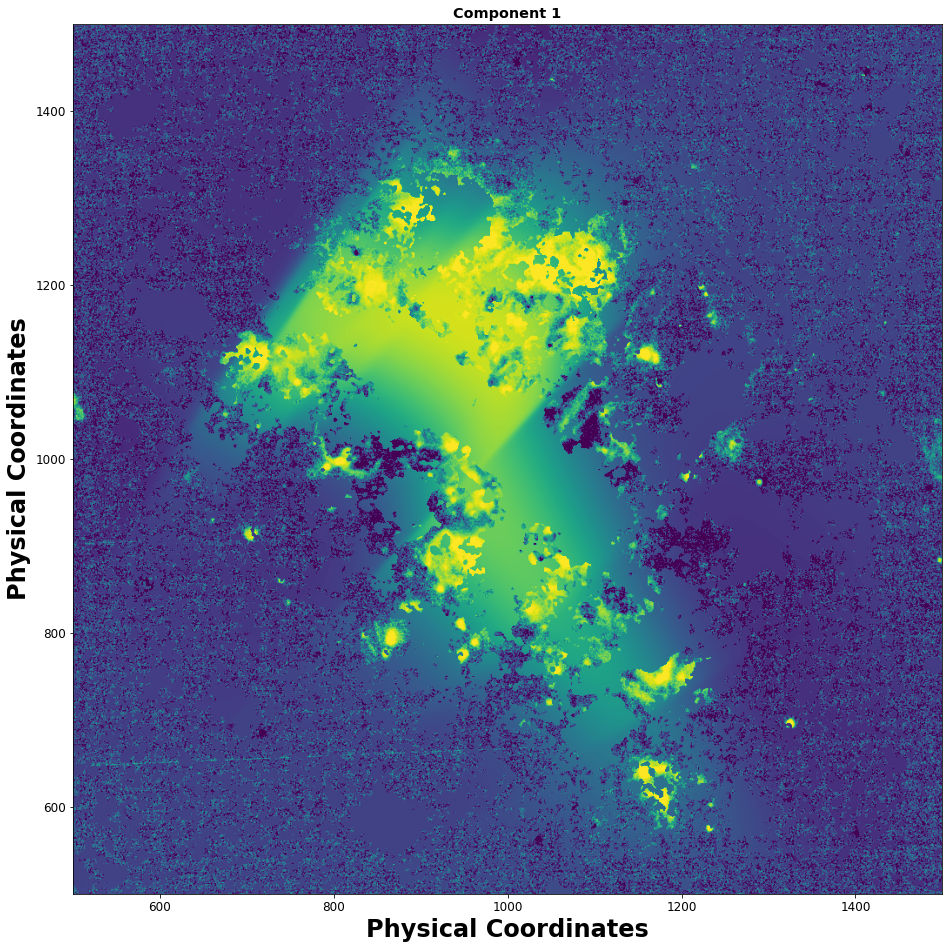

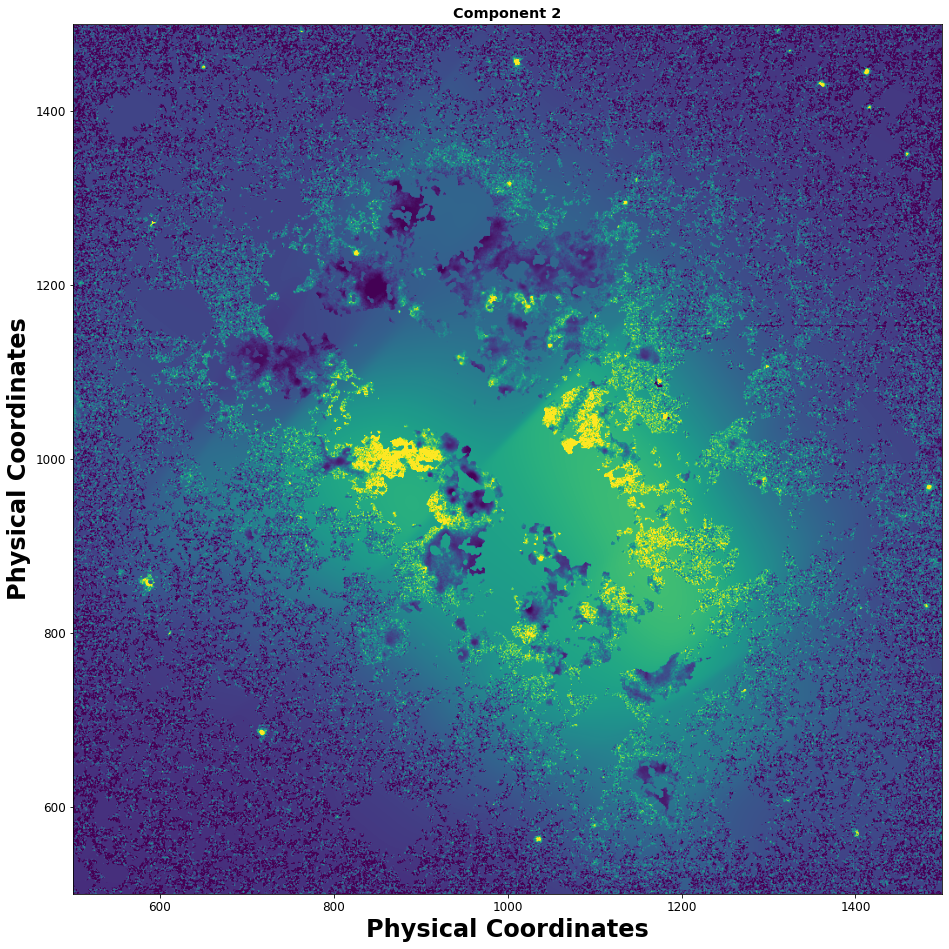

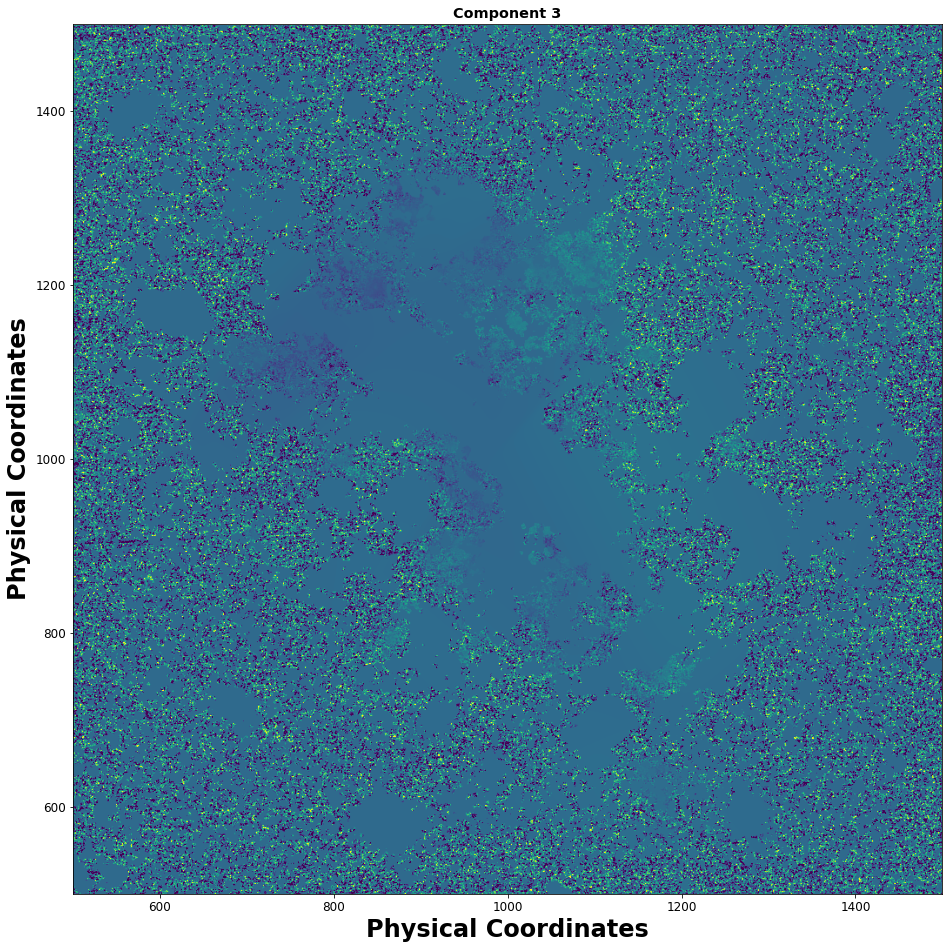

In [4]:
BkgTransformedPCA, pca, interpolatedSourcePixels, idx_bkg, idx_src, coefficient_array = cube.create_background_subspace(x_min=500, x_max=1500, y_min=500, y_max=1500, 
                                                                                                     n_components=n_components, n_components_keep=n_components_keep)

In [5]:
np.nanstd(interpolatedSourcePixels[:,])

0.37003928

In [6]:
import pickle
pickle.dump(idx_bkg, open('/export/home/carterrhea/NGC4449/idx_bkg.pkl', 'wb'))
pickle.dump(idx_src, open('/export/home/carterrhea/NGC4449/idx_src.pkl', 'wb'))
pickle.dump(cube.spectrum_axis, open('/export/home/carterrhea/NGC4449/spectrum_axis.pkl', 'wb'))
pickle.dump(BkgTransformedPCA, open('/export/home/carterrhea/NGC4449/BkgTransformedPCA.pkl', 'wb'))

#pickle.dump(cube.cube_final, open('/export/home/carterrhea/NGC4449/cube_final.pkl','wb'))

In [7]:
import numpy as np
min_spectral_scale = np.argmin(np.abs([1e7 / wavelength - 675 for wavelength in cube.spectrum_axis]))
max_spectral_scale = np.argmin(np.abs([1e7 / wavelength - 670 for wavelength in cube.spectrum_axis]))

spec_scale = np.nanmax(cube.cube_final[600, 700, min_spectral_scale:max_spectral_scale])
max_spectral = np.argmin(np.abs([1e7 / wavelength - 646 for wavelength in cube.spectrum_axis]))
min_spectral = np.argmin(np.abs([1e7 / wavelength - 678 for wavelength in cube.spectrum_axis]))

reconstructed_spectra = pca.mean_ + np.sum([pca.components_[i] * interpolatedSourcePixels[10][i] for i in range(1, n_components_keep)], axis=0)


In [8]:
print(spec_scale)

4.4869332857239605e-18


In [9]:
bkg_axis, bkg_sky = cube.extract_spectrum_region(cube_dir+'/bkg.reg', mean=True)

100%|███████████████████████████████████████████████████████████| 2064/2064 [00:01<00:00, 1377.28it/s]


findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


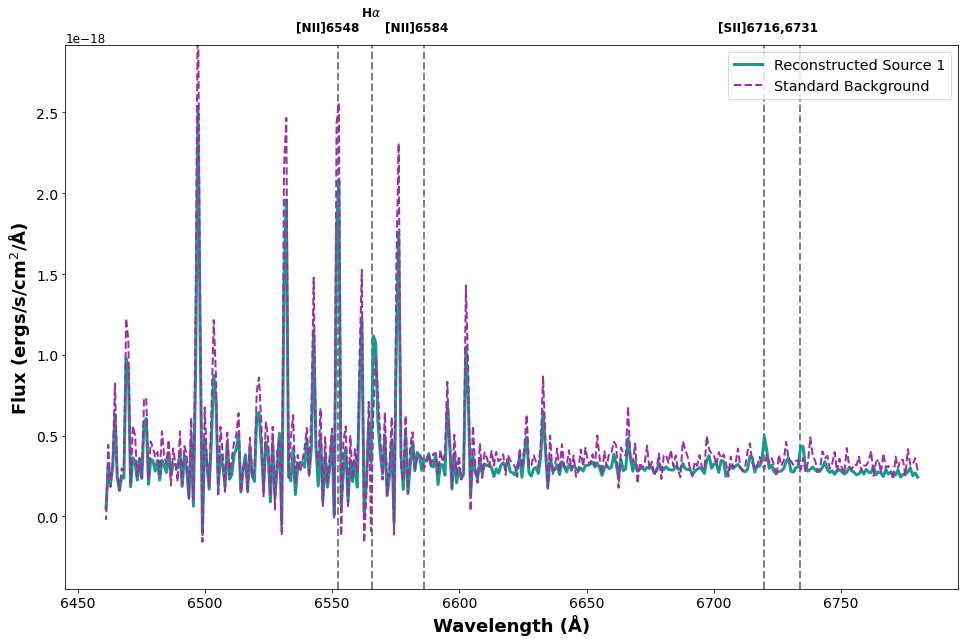

In [10]:
fig, ax = plt.subplots()

#plt.plot(1e7/cube.spectrum_axis[min_spectral: max_spectral], pca.mean_-np.sum([pca.components_[i] * BkgTransformedPCA[0,i] for i in range(n_components_keep)], axis=0), label='Reconstructed Bkg 1')
#plt.plot(1e7/cube.spectrum_axis[min_spectral: max_spectral], pca.mean_, linewidth=3, `linestyle='-.', label='Mean')
plt.plot(1e8/cube.spectrum_axis[min_spectral: max_spectral],
         spec_scale*reconstructed_spectra,
         linewidth=3, linestyle='-', label='Reconstructed Source 1')
plt.plot(1e8/cube.spectrum_axis[min_spectral: max_spectral], bkg_sky[min_spectral: max_spectral], label='Standard Background', linestyle='--')
plt.vlines((10*654.95*(1+redshift), 10*656.3*(1+redshift), 10*658.35*(1+redshift), 10*671.7*(1+redshift), 10*673.1*(1+redshift)), -0.1*spec_scale, 0.65*spec_scale, linestyle='--', color='grey')
ax.text(s=r'[NII]6548', x=10*654.8*(1+redshift)-15, y=0.67*spec_scale, fontsize='large', fontweight='heavy') 
ax.text(s=r'H$\alpha$', x=10*656.3*(1+redshift)-4.5, y=0.69*spec_scale, fontsize='large', fontweight='heavy') 
ax.text(s=r'[NII]6584', x=10*658.3*(1+redshift)-15, y=0.67*spec_scale, fontsize='large', fontweight='heavy') 
ax.text(s=r'[SII]6716,6731', x=10*671.7*(1+redshift)-18, y=0.67*spec_scale, fontsize='large', fontweight='heavy') 
#ax.text(s=r'[SII]6731', x=673.1*(1+redshift)-1.5, y=0.67*spec_scale, fontsize='large', fontweight='heavy') 


#plt.ylim(-0.1, 0.6)
plt.ylim(-0.1*spec_scale, 0.65*spec_scale)
plt.legend()
plt.xlabel('Wavelength (Å)', fontsize=18, fontweight='bold', fontname='Roboto')
plt.ylabel(r'Flux (ergs/s/cm$^{2}$/Å)', fontsize=18, fontweight='bold', fontname='Roboto')
ax.tick_params(labelsize=14)
#plt.savefig('/export/home/carterrhea/NGC4449/Backgrounds.png')

In [11]:
np.std([val[0] for val in interpolatedSourcePixels])

0.5353284

(array([5.00000e+00, 3.10000e+01, 8.20000e+01, 1.38700e+03, 4.90550e+04,
        2.75975e+05, 1.52782e+05, 3.23180e+04, 3.67690e+04, 3.20100e+03]),
 array([-3.82422552, -3.18957411, -2.5549227 , -1.92027129, -1.28561989,
        -0.65096848, -0.01631707,  0.61833434,  1.25298574,  1.88763715,
         2.52228856]),
 <BarContainer object of 10 artists>)

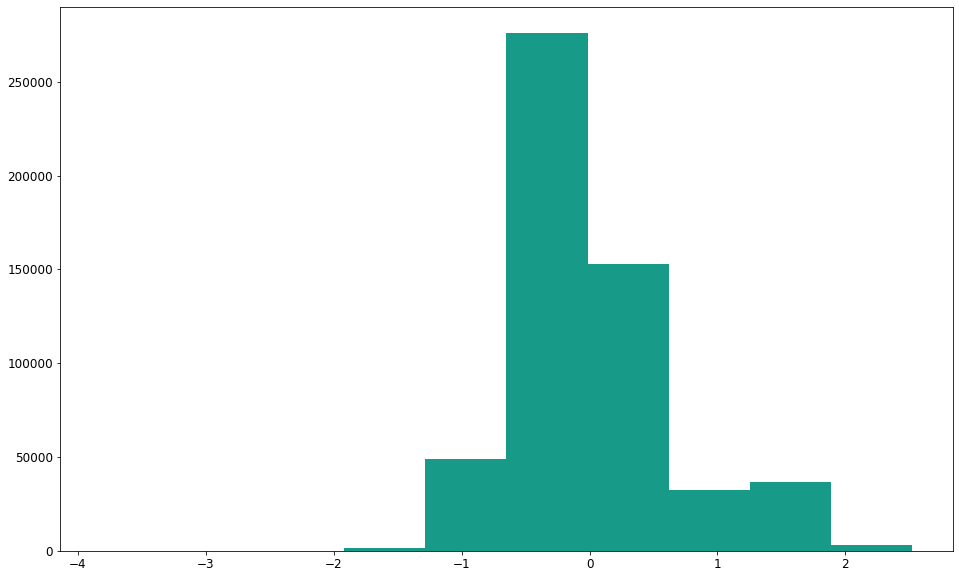

In [12]:
plt.hist([val[0] for val in BkgTransformedPCA])

# Check if a component is noise
We can estimate whether or not a component is noise-dominated (i.e. not containing any useful signal) by calculating the *n*-point correlation function. If the value of the function for a spectrum is near zero, then the spectrum is pure noise.


In [13]:
corr = two_point(pca.components_[0], len(pca.components_[0]))
print(corr)

ValueError: bins must be a 1D array

In [ ]:
cube.fit_cube(['Halpha', 'NII6583', 'NII6548'], 
                 'sinc', 
                 [1,1,1], [1,1,1],
                 #950, 1100, 950, 1100, 
                  600, 1540, 500, 1500,
                 spec_min= 15000, spec_max = 15500,
                 bkgType='pca', n_threads=20, binning=1, bayes_bool=False, n_stoch=1,
                 pca_coefficient_array=coefficient_array, pca_vectors=pca.components_, pca_mean=pca.mean_
             )

  2%|█▎                                                             | 20/1000 [00:13<10:44,  1.52it/s]WARNING:tensorflow:From /home/carterrhea/anaconda3/envs/luci/lib/python3.9/site-packages/tensorflow/python/util/deprecation.py:561: calling function (from tensorflow.python.eager.polymorphic_function.polymorphic_function) with experimental_relax_shapes is deprecated and will be removed in a future version.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instruct